## Introduction to AIF360 with several measuring and mitigation techniques

In [ ]:
#note: neither virtual environment nor normal pip installed library of AIF360 contains the dataset. It gave an error in the next
#step and I had to download the dataset manually from the link given in the error message.
import sys
sys.path.insert(1, "../")  

import numpy as np
np.random.seed(0)

import lime
import lime.lime_tabular

from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from aif360.metrics.binary_label_dataset_metric import BinaryLabelDatasetMetric
from aif360.metrics.classification_metric import ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.reweighing import Reweighing

from IPython.display import Markdown, display

### Mitigation on German Credit Dataset

In [ ]:
#Note:this dataset also contains protected attribute for "sex" which is not considered in this evaluation age >=25 is privileged
dataset_orig = GermanDataset(
    protected_attribute_names=['age'],                                                         
    privileged_classes=[lambda x: x >= 25],      
    features_to_drop=['personal_status', 'sex'] # ignore sex-related attributes
)
#train-test split function
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

print(dataset_orig_train)
#I see that it is aif360.dataset type, the data cannot be manipulated using any scikit functionalities.
print(type(dataset_orig_train))

NOTE: There is a column inserted in the dataset called "instance weights features". It is probably for this algorithm speficically. Reweighing algorithms changes the values in this column.

In [ ]:
#One simple test is to compare the percentage of favorable results for the privileged and unprivileged groups, subtracting the
#former percentage from the latter. A negative value indicates less favorable outcomes for the unprivileged groups.
#This is implemented in the method called mean_difference on the BinaryLabelDatasetMetric class.
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

In [ ]:
#Mitigating the unfairness with "Reweighing" preprocessing algorithm (Kamiran & Calders' algorithm)

RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)
dataset_transf_train

In [ ]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

In [ ]:
#Training a logistic regression model on preprocessed fair dataset to test the predictions

trainset = dataset_transf_train  # data to train on
scale = StandardScaler().fit(trainset.features)   # remember the scale
model = LogisticRegression()        # model to learn

X_train = scale.transform(trainset.features)      #apply the scale
y_train = trainset.labels.ravel()

model.fit(X_train, y_train, sample_weight=trainset.instance_weights)

#save model
lr_orig = model
lr_scale_orig = scale

print(X_train)
print(y_train)

In [ ]:
#Test model on given dataset and find threshold for best balanced accuracy
import numpy as np

#tqdm makes your loops show a smart progress meter. It can also be executed as a module with pipes, which will be used here.
from tqdm import tqdm
thresh_arr = np.linspace(0.01, 0.5, 50)

scale = lr_scale_orig

model = lr_orig                  #model to test
testset = dataset_orig_test        #data to test on

X_test = scale.transform(testset.features)   #apply the same scale as applied to the training data
y_test = testset.labels.ravel()
y_test_pred_prob = model.predict_proba(X_test)

#collecting various performance metrics
bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
    
for thresh in tqdm(thresh_arr):
    y_test_pred = (y_test_pred_prob[:,1] > thresh).astype(np.double)

    testset_pred = testset.copy()
    testset_pred.labels = y_test_pred

    classified_metric = ClassificationMetric(testset, 
                                                 testset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metric_pred = BinaryLabelDatasetMetric(testset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    
    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    bal_acc = 0.5*(TPR+TNR)
    
    acc = accuracy_score(y_true=testset.labels,
                            y_pred=testset_pred.labels)
    bal_acc_arr.append(bal_acc)
    avg_odds_diff_arr.append(classified_metric.average_odds_difference())
    disp_imp_arr.append(metric_pred.disparate_impact())
    
thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
disp_imp_at_best_bal_acc = np.abs(1.0-np.array(disp_imp_arr))[thresh_arr_best_ind]

avg_odds_diff_at_best_bal_acc = avg_odds_diff_arr[thresh_arr_best_ind]

In [ ]:
#plotting the balanced accuracy, abs(1-disparate impact)
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, np.abs(1.0-np.array(disp_imp_arr)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [ ]:
#Plot average odds difference
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(thresh_arr, avg_odds_diff_arr, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [ ]:
rf_thresh_arr_orig_best = thresh_arr_best
print("Threshold corresponding to Best balance accuracy: %6.4f" % rf_thresh_arr_orig_best)
rf_best_bal_acc_arr_orig = best_bal_acc
print("Best balance accuracy: %6.4f" % rf_best_bal_acc_arr_orig)
rf_disp_imp_at_best_bal_acc_orig = disp_imp_at_best_bal_acc
print("Corresponding abs(1-disparate impact) value: %6.4f" % rf_disp_imp_at_best_bal_acc_orig)
rf_avg_odds_diff_at_best_bal_acc_orig = avg_odds_diff_at_best_bal_acc
print("Corresponding average odds difference value: %6.4f" % rf_avg_odds_diff_at_best_bal_acc_orig)

In [ ]:
from aif360.datasets.lime_encoder import LimeEncoder 

limeData = LimeEncoder().fit(dataset_orig_train)
s_train = limeData.transform(dataset_orig_train.features)
s_test = limeData.transform(dataset_orig_test.features)

scale = lr_scale_orig

model = lr_orig                  #model to test




explainer = lime.lime_tabular.LimeTabularExplainer(s_train ,class_names=limeData.s_class_names, 
                                                   feature_names = limeData.s_feature_names,
                                                   categorical_features=limeData.s_categorical_features, 
                                                   categorical_names=limeData.s_categorical_names, 
                                                   kernel_width=3, verbose=False,discretize_continuous=True)

s_predict_fn = lambda x: model.predict_proba(scale.transform(limeData.inverse_transform(x)))

import random
print("Threshold corresponding to Best balance accuracy: %6.4f" % rf_thresh_arr_orig_best)
i1 = 1
exp = explainer.explain_instance(s_test[i1], s_predict_fn, num_features=5)
exp.as_pyplot_figure()
print("        Actual label: " + str(dataset_orig_test.labels[i1]))

i2 = 100
exp = explainer.explain_instance(s_test[i2], s_predict_fn, num_features=5)
exp.as_pyplot_figure()
print("        Actual label: " + str(dataset_orig_test.labels[i2]))

### Mitigation on Adult Dataset (scikit-learn compatible!)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

from aif360.sklearn.preprocessing import ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr, equal_opportunity_difference
from aif360.sklearn.metrics import generalized_fnr, difference

In [2]:
#Datasets are formatted as separate X (# samples x # features) and y (# samples x # labels) DataFrames. The index of each DataFrame contains protected attribute values per sample. Datasets may also load a sample_weight object to be used with certain algorithms/metrics. All of this makes it so that aif360 is compatible with scikit-learn objects
    
X, y, sample_weight = fetch_adult()
X.head()  

,,,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
,race,sex,,,,,,,,,,,,,
0,Non-white,Male,25.0,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Non-white,Male,0.0,0.0,40.0,United-States
1,White,Male,38.0,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,White,Male,28.0,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,Non-white,Male,44.0,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Non-white,Male,7688.0,0.0,40.0,United-States
5,White,Male,34.0,Private,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States


In [3]:
y.head()

   race       sex 
0  Non-white  Male    <=50K
1  White      Male    <=50K
2  White      Male     >50K
3  Non-white  Male     >50K
5  White      Male    <=50K
Name: annual-income, dtype: category
Categories (2, object): ['<=50K' < '>50K']

In [4]:
#We can then map the protected attributes to integers
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)
print(X.head())
print(y.head())

             age  workclass     education  education-num      marital-status  \
  race sex                                                                     
0 0    1    25.0    Private          11th            7.0       Never-married   
1 1    1    38.0    Private       HS-grad            9.0  Married-civ-spouse   
2 1    1    28.0  Local-gov    Assoc-acdm           12.0  Married-civ-spouse   
3 0    1    44.0    Private  Some-college           10.0  Married-civ-spouse   
5 1    1    34.0    Private          10th            6.0       Never-married   

                   occupation   relationship       race   sex  capital-gain  \
  race sex                                                                    
0 0    1    Machine-op-inspct      Own-child  Non-white  Male           0.0   
1 1    1      Farming-fishing        Husband      White  Male           0.0   
2 1    1      Protective-serv        Husband      White  Male           0.0   
3 0    1    Machine-op-inspct        Husband

In [5]:
# change the target classes with 0 and 1
y = pd.Series(y.factorize(sort=True)[0], index=y.index)
y.head()

   race  sex
0  0     1      0
1  1     1      0
2  1     1      1
3  0     1      1
5  1     1      0
dtype: int64

In [6]:
#split the train and test set, then encode the categorical features using one-hot encoder
(X_train, X_test, y_train, y_test) = train_test_split(X, y, train_size=0.7, random_state=1234567)

ohe = make_column_transformer((OneHotEncoder(sparse=False), X_train.dtypes == 'category'),
                            remainder='passthrough')
X_train = pd.DataFrame(ohe.fit_transform(X_train), index=X_train.index)
X_test = pd.DataFrame(ohe.transform(X_test), index=X_test.index)

X_train.head()

#Note: the column names are lost in this transformation. The same encoding can be done with Pandas, but this cannot be combined
#with other preprocessing in a Pipeline.

,,,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
,race,sex,,,,,,,,,,,,,,,,,,,,,
30149,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,58.0,11.0,0.0,0.0,42.0
12028,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,51.0,12.0,0.0,0.0,30.0
36374,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,26.0,14.0,0.0,1887.0,40.0
8055,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,44.0,3.0,0.0,0.0,40.0
38108,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,33.0,6.0,0.0,0.0,40.0


In [7]:
# there is one unused category ('Never-worked') that was dropped during dropna
# get_dummies: pandas library's categorical variable converter into dummy/indicator variables.
X.workclass.cat.remove_unused_categories(inplace=True)
pd.get_dummies(X).head()

,,,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
,race,sex,,,,,,,,,,,,,,,,,,,,,
0,0,1,25.0,7.0,0.0,0.0,40.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,1,38.0,9.0,0.0,0.0,50.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,1,28.0,12.0,0.0,0.0,40.0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,44.0,10.0,7688.0,0.0,40.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5,1,1,34.0,6.0,0.0,0.0,30.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Metrics

In [8]:
#I increased the max_iter object's value to 10000 from 100 in _logistic.py to prevent convergence error.
y_pred = LogisticRegression(solver='lbfgs').fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_pred)

0.8470553549052848

In [9]:
#disparate impact check (unprivileged group's positive outcome rate/privileged group's positive outcome rate)
disparate_impact_ratio(y_test, y_pred, prot_attr='sex')

0.306693066127975

In [10]:
disparate_impact_ratio(y_test, y_pred, prot_attr='race')

0.513408447871844

In [11]:
#average_odds_error() computes the (unweighted) average of the absolute values of the true positive rate (TPR) difference and 
#false positive rate (FPR) difference
average_odds_error(y_test, y_pred, prot_attr='sex')

0.08209643421346868

In [12]:
average_odds_error(y_test, y_pred, prot_attr='race')

0.06569245398649454

#### Debiasing Algorithms

ReweighingMeta is a workaround until changing sample weights can be handled properly in Pipeline/GridSearchCV

In [13]:
rew = ReweighingMeta(estimator=LogisticRegression(solver='lbfgs'))
params = {'estimator__C': [1, 10], 'reweigher__prot_attr': ['sex']}

clf = GridSearchCV(rew, params, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.best_params_)

0.8404216112626225
{'estimator__C': 1, 'reweigher__prot_attr': 'sex'}


In [14]:
params2 = {'estimator__C': [1, 10], 'reweigher__prot_attr': ['race']}

clf2 = GridSearchCV(rew, params2, scoring='accuracy', cv=5)
clf2.fit(X_train, y_train)
print(clf2.score(X_test, y_test))
print(clf2.best_params_)

0.8450652318124862
{'estimator__C': 10, 'reweigher__prot_attr': 'race'}


In [15]:
print("For gender:")
print("Disparate impact ratio-", disparate_impact_ratio(y_test, clf.predict(X_test), prot_attr='sex'))
print("Average odds error-", average_odds_error(y_test, clf.predict(X_test), prot_attr='sex'))
print("Equal oppotunity difference=", equal_opportunity_difference(y_test, clf.predict(X_test), prot_attr='sex'))
print("For race:")
print("Disparate impact ratio-", disparate_impact_ratio(y_test, clf2.predict(X_test), prot_attr='race'))
print("Average odds error-", average_odds_error(y_test, clf2.predict(X_test), prot_attr='race'))
print("Equal oppotunity difference=", equal_opportunity_difference(y_test, clf2.predict(X_test), prot_attr='race'))

For gender:
Disparate impact ratio- 0.597239412476256
Average odds error- 0.0848214275444617
Equal oppotunity difference= 0.15453677628752804
For race:
Disparate impact ratio- 0.7005607368861085
Average odds error- 0.019024797349856126
Equal oppotunity difference= 0.024531863485351857


#### Adverserial debiasing in-processing algorithm

In [16]:
adv_deb = AdversarialDebiasing(prot_attr='sex', random_state=1234567)
adv_deb.fit(X_train, y_train)
print(adv_deb.score(X_test, y_test))

adv_deb2 = AdversarialDebiasing(prot_attr='race', random_state=1234567)
adv_deb2.fit(X_train, y_train)
print(adv_deb2.score(X_test, y_test))

0.8399056534237488
0.840569027788015


In [17]:
print("For gender:")
print("Disparate impact ratio=", disparate_impact_ratio(y_test, adv_deb.predict(X_test), prot_attr='sex'))
print("Average odds error=", average_odds_error(y_test, adv_deb.predict(X_test), prot_attr='sex'))
print("Equal oppotunity difference=", equal_opportunity_difference(y_test, adv_deb.predict(X_test), prot_attr='sex'))

print("For race:")
print("Disparate impact ratio=", disparate_impact_ratio(y_test, adv_deb2.predict(X_test), prot_attr='race'))
print("Average odds error=", average_odds_error(y_test, adv_deb2.predict(X_test), prot_attr='race'))
print("Equal oppotunity difference=", equal_opportunity_difference(y_test, adv_deb2.predict(X_test), prot_attr='race'))

For gender:
Disparate impact ratio= 0.5388528021085786
Average odds error= 0.060623189820735834
Equal oppotunity difference= 0.10739821488234447
For race:
Disparate impact ratio= 1.0833962821860221
Average odds error= 0.11002622907329035
Equal oppotunity difference= 0.1768951978254304


In [18]:
#NOTE: AdversarialDebiasing creates a TensorFlow session which we should close when we're finished to free up resources:
adv_deb.sess_.close()

#### CalibratedEqualizedOdds: a post-processing algorithm

Since the post-processor needs to be trained on data unseen by the original estimator, we will use the PostProcessingMeta class
which splits the data and trains the estimator and post-processor with their own split.

In [19]:
log_reg = LogisticRegression(solver='lbfgs')

#for gender
cal_eq_odds = CalibratedEqualizedOdds('sex', cost_constraint='fnr', random_state=1234567)
postproc = PostProcessingMeta(estimator=log_reg, postprocessor=cal_eq_odds, random_state=1234567)

postproc.fit(X_train, y_train)
print("Gender:", accuracy_score(y_test, postproc.predict(X_test)))

#for race
cal_eq_odds2 = CalibratedEqualizedOdds('race', cost_constraint='fnr', random_state=1234567)
postproc2 = PostProcessingMeta(estimator=log_reg, postprocessor=cal_eq_odds2, random_state=1234567)

postproc2.fit(X_train, y_train)
print("Race:", accuracy_score(y_test, postproc2.predict(X_test)))

Gender: 0.8200044224957618
Race: 0.839979361686445


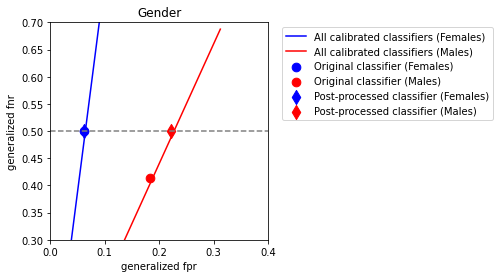

In [21]:
#Representing changes per sensitive attribute subgroup with visualizations (for gender)
y_pred = postproc.predict_proba(X_test)[:, 1]
y_lr = postproc.estimator_.predict_proba(X_test)[:, 1]
br = postproc.postprocessor_.base_rates_
i = X_test.index.get_level_values('sex') == 1

plt.plot([0, br[0]], [0, 1-br[0]], '-b', label='All calibrated classifiers (Females)')
plt.plot([0, br[1]], [0, 1-br[1]], '-r', label='All calibrated classifiers (Males)')

plt.scatter(generalized_fpr(y_test[~i], y_lr[~i]),
            generalized_fnr(y_test[~i], y_lr[~i]),
            300, c='b', marker='.', label='Original classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_lr[i]),
            generalized_fnr(y_test[i], y_lr[i]),
            300, c='r', marker='.', label='Original classifier (Males)')
                                                                        
plt.scatter(generalized_fpr(y_test[~i], y_pred[~i]),
            generalized_fnr(y_test[~i], y_pred[~i]),
            100, c='b', marker='d', label='Post-processed classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_pred[i]),
            generalized_fnr(y_test[i], y_pred[i]),
            100, c='r', marker='d', label='Post-processed classifier (Males)')

plt.plot([0, 1], [generalized_fnr(y_test, y_pred)]*2, '--', c='0.5')

plt.axis('square')
plt.title("Gender")
plt.xlim([0.0, 0.4])
plt.ylim([0.3, 0.7])
plt.xlabel('generalized fpr');
plt.ylabel('generalized fnr');
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left');

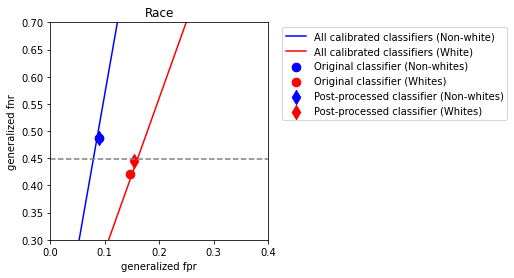

In [24]:
#Representing changes per sensitive attribute subgroup with visualizations (for race)
y_pred = postproc2.predict_proba(X_test)[:, 1]
y_lr = postproc2.estimator_.predict_proba(X_test)[:, 1]
br = postproc2.postprocessor_.base_rates_
i = X_test.index.get_level_values('race') == 1

plt.plot([0, br[0]], [0, 1-br[0]], '-b', label='All calibrated classifiers (Non-white)')
plt.plot([0, br[1]], [0, 1-br[1]], '-r', label='All calibrated classifiers (White)')

'''NOTE: The bitwise operator ~ (pronounced as tilde) is a complement operator. It takes one bit operand and returns its 
complement. If the operand is 1, it returns 0, and if it is 0, it returns 1'''

plt.scatter(generalized_fpr(y_test[~i], y_lr[~i]),
            generalized_fnr(y_test[~i], y_lr[~i]),
            300, c='b', marker='.', label='Original classifier (Non-whites)')
plt.scatter(generalized_fpr(y_test[i], y_lr[i]),
            generalized_fnr(y_test[i], y_lr[i]),
            300, c='r', marker='.', label='Original classifier (Whites)')
                                                                        
plt.scatter(generalized_fpr(y_test[~i], y_pred[~i]),
            generalized_fnr(y_test[~i], y_pred[~i]),
            100, c='b', marker='d', label='Post-processed classifier (Non-whites)')
plt.scatter(generalized_fpr(y_test[i], y_pred[i]),
            generalized_fnr(y_test[i], y_pred[i]),
            100, c='r', marker='d', label='Post-processed classifier (Whites)')

plt.plot([0, 1], [generalized_fnr(y_test, y_pred)]*2, '--', c='0.5')

plt.axis('square')
plt.title('Race')
plt.xlim([0.0, 0.4])
plt.ylim([0.3, 0.7])
plt.xlabel('generalized fpr');
plt.ylabel('generalized fnr');
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left');

We can see the generalized false negative rate is approximately equalized and the classifiers remain close to the calibration lines. We can quanitify the discrepancy between protected groups using the difference operator:

In [25]:
print(difference(generalized_fnr, y_test, y_pred, prot_attr='sex'))

print(difference(generalized_fnr, y_test, y_pred, prot_attr='race'))

0.08405224398402267
0.04211462602860394


## Exercise on how to use LIME (Local Interpretable Model-Agnostic Explanations) to generate explanations for model predictions

In [26]:

%matplotlib inline

import sklearn.model_selection
import sklearn.metrics
import sklearn.datasets
import sklearn.ensemble
import sklearn.preprocessing
import numpy as np
import lime
import lime.lime_tabular
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import numpy as np
from aif360.datasets import BinaryLabelDataset
from aif360.metrics.binary_label_dataset_metric import BinaryLabelDatasetMetric
from aif360.metrics.classification_metric import ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.reweighing import Reweighing

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from aif360.datasets.lime_encoder import LimeEncoder 


from aif360.datasets.adult_dataset import AdultDataset

In [27]:
np.random.seed(1)
#Dataset is not scikit-learn compatible
dataset_orig = AdultDataset()
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [28]:
# Metric for the original dataset
sens_attr = dataset_orig_train.protected_attribute_names[0]
sens_idx = dataset_orig_train.protected_attribute_names.index(sens_attr)

privileged_groups = [{sens_attr:dataset_orig_train.privileged_protected_attributes[sens_idx][0]}] 
unprivileged_groups = [{sens_attr:dataset_orig_train.unprivileged_protected_attributes[sens_idx][0]}]

#BinaryLabelDatasetMetric() is the class for computing metrics based on a single BinaryLabelDataset.
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between privileged and unprivileged groups = -0.106968


#### Mitigating the unfairness using pre-processing algorithm: re-weighing

In [29]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

#### Learn and test models from the transformed data using Random Forests

In [30]:
#Train model on given dataset

dataset = dataset_transf_train  # data to train on
scale = StandardScaler().fit(dataset.features)   # remember the scale
model = sklearn.ensemble.RandomForestClassifier(n_estimators=500)       # model to learn

X_train = scale.transform(dataset.features)      #apply the scale
y_train = dataset.labels.ravel()

model.fit(X_train, y_train, sample_weight=dataset.instance_weights)

#save model
rf_orig = model
rf_scale_orig = scale

In [31]:
#Test model on given dataset and find threshold for best balanced accuracy
import numpy as np
from tqdm import tqdm
thresh_arr = np.linspace(0.01, 0.5, 50)

scale = rf_scale_orig

model = rf_orig                  #model to test
dataset = dataset_orig_test        #data to test on

X_test = scale.transform(dataset.features)   #apply the same scale as applied to the training data
y_test = dataset.labels.ravel()
y_test_pred_prob = model.predict_proba(X_test)


bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
    
for thresh in tqdm(thresh_arr):
    y_test_pred = (y_test_pred_prob[:,1] > thresh).astype(np.double)

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_test_pred

    classified_metric = ClassificationMetric(dataset, 
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    
    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    bal_acc = 0.5*(TPR+TNR)
    
    acc = accuracy_score(y_true=dataset.labels,
                            y_pred=dataset_pred.labels)
    bal_acc_arr.append(bal_acc)
    avg_odds_diff_arr.append(classified_metric.average_odds_difference())
    disp_imp_arr.append(metric_pred.disparate_impact())
    
thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
disp_imp_at_best_bal_acc = np.abs(1.0-np.array(disp_imp_arr))[thresh_arr_best_ind]

avg_odds_diff_at_best_bal_acc = avg_odds_diff_arr[thresh_arr_best_ind]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.49it/s]


#### Plotting performace measures

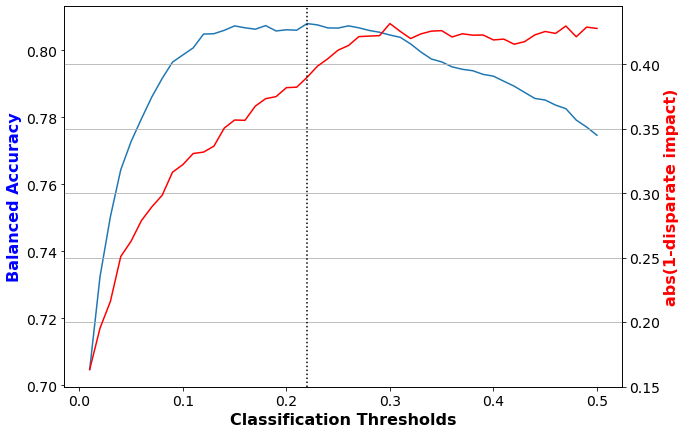

In [32]:
#Plot balanced accuracy, abs(1-disparate impact)

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, np.abs(1.0-np.array(disp_imp_arr)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

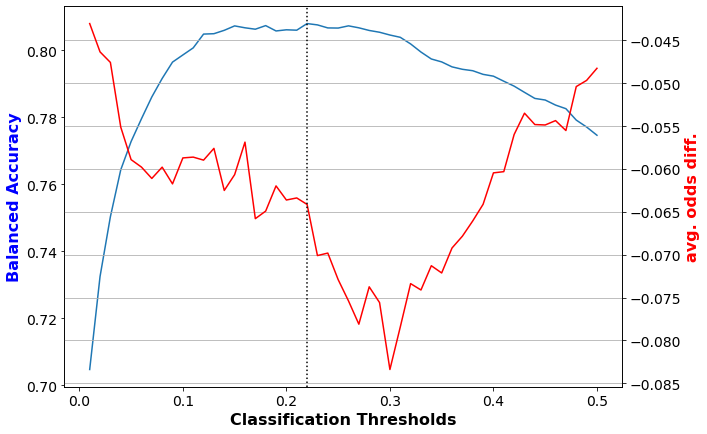

In [33]:
#Plot average odds difference
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, avg_odds_diff_arr, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [35]:
rf_thresh_arr_orig_best = thresh_arr_best
print("Threshold corresponding to Best balance accuracy: %6.4f" % rf_thresh_arr_orig_best)
rf_best_bal_acc_arr_orig = best_bal_acc
print("Best balance accuracy: %6.4f" % rf_best_bal_acc_arr_orig)
rf_disp_imp_at_best_bal_acc_orig = disp_imp_at_best_bal_acc
print("Corresponding abs(1-disparate impact) value: %6.4f" % rf_disp_imp_at_best_bal_acc_orig)
rf_avg_odds_diff_at_best_bal_acc_orig = avg_odds_diff_at_best_bal_acc
print("Corresponding average odds difference value: %6.4f" % rf_avg_odds_diff_at_best_bal_acc_orig)

Threshold corresponding to Best balance accuracy: 0.2200
Best balance accuracy: 0.8080
Corresponding abs(1-disparate impact) value: 0.3898
Corresponding average odds difference value: -0.0641


#### Use LIME to generate explanations for predictions made using the learnt Logistic Regression model

Threshold corresponding to Best balance accuracy: 0.2200
        Actual label: [1.]
        Actual label: [0.]


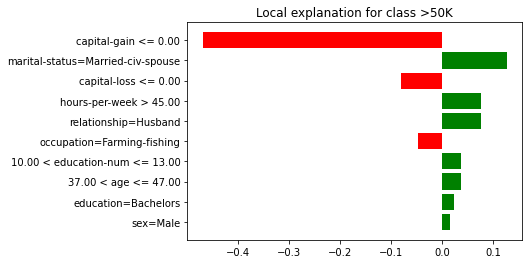

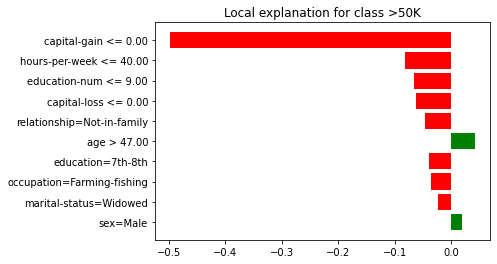

In [49]:
limeData = LimeEncoder().fit(dataset_orig_train)
s_train = limeData.transform(dataset_orig_train.features)
s_test = limeData.transform(dataset_orig_test.features)

scale = rf_scale_orig
model = rf_orig                  #model to test

#some samples (individuals) from the test set based on their index
i1 = 1
i2 = 100

explainer = lime.lime_tabular.LimeTabularExplainer(s_train ,class_names=limeData.s_class_names, 
                                                   feature_names = limeData.s_feature_names,
                                                   categorical_features=limeData.s_categorical_features, 
                                                   categorical_names=limeData.s_categorical_names, 
                                                   kernel_width=3, verbose=False,discretize_continuous=True)

s_predict_fn = lambda x: model.predict_proba(scale.transform(limeData.inverse_transform(x)))

import random
print("Threshold corresponding to Best balance accuracy: %6.4f" % rf_thresh_arr_orig_best)

exp = explainer.explain_instance(s_test[i1], s_predict_fn, num_features=10)
exp.as_pyplot_figure()
print("        Actual label: " + str(dataset_orig_test.labels[i1]))


exp = explainer.explain_instance(s_test[i2], s_predict_fn, num_features=10)
exp.as_pyplot_figure()
print("        Actual label: " + str(dataset_orig_test.labels[i2]))

In [39]:
s_test[i1]

array([41., 13.,  1.,  1.,  0.,  0., 75.,  4.,  9.,  2.,  4.,  0., 38.])

        Actual label: [1.]


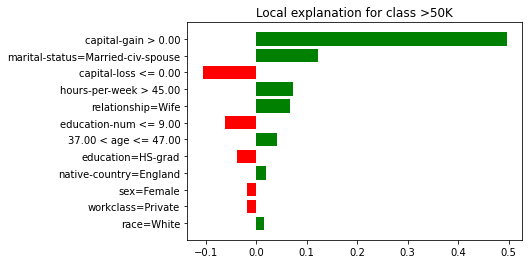

In [48]:
i3 = 63
exp = explainer.explain_instance(s_test[i3], s_predict_fn, num_features=12)
exp.as_pyplot_figure()
print("        Actual label: " + str(dataset_orig_test.labels[i3]))

        Actual label: [1.]


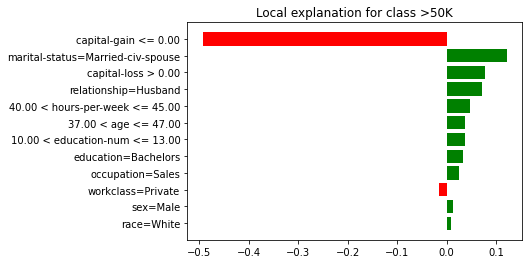

In [46]:
i4 = 38
exp = explainer.explain_instance(s_test[i4], s_predict_fn, num_features=12)
exp.as_pyplot_figure()
print("        Actual label: " + str(dataset_orig_test.labels[i4]))